## Boring Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
logging.getLogger().setLevel(logging.DEBUG)

import json
import os
import trappy
from trace import Trace
from executor import Executor

import numpy as np
import pandas as pd

from bart.common.Utils import select_window, area_under_curve

from trappy.stats.Topology import Topology

from perf_analysis import PerfAnalysis


In [2]:
from tests.eas.acceptance import ManyTasksLowestEnergy

In [3]:
events = [
            "sched_overutilized",
            "sched_migrate_task",
            "sched_load_avg_task",
            "sched_load_avg_cpu",
            "sched_switch",
            "cpu_idle",
            "cpu_frequency",
            "irq*"
        ]

In [4]:
run_workload = False

In [ ]:
def get_rtapp_params(trace_dir):
    wload_name = os.path.split(trace_dir)[-2].split("::")[-1]
    rtapp_json_path = os.path.join(trace_dir, "{}_00.json".format(wload_name))
    with open(rtapp_json_path) as f:
        rtapp_params = json.load(f)["tasks"]
    return rtapp_params
    
    topology = Topology(platform["topology"])

## Running Workload

In [5]:
if run_workload:
    global platform, trace_path,tasks, topology

    ManyTasksLowestEnergy.setUpClass()
    
    energy_model = ManyTasksLowestEnergy.executor.te.nrg_model
    executor = ManyTasksLowestEnergy.executor
    experiment = executor.experiments[0]
    trace_path = experiment.out_dir
    platform = executor.te.platform
    topology = Topology(platform["topology"])
    tasks = experiment.wload.tasks.keys()
    rtapp_params = get_rtapp_params()

## OR, not running workload

In [8]:
from platforms.juno_energy import juno_energy
from platforms.hikey_energy import hikey_energy


if not run_workload:
    trace_path = "/home/brejac01/sources/lisa/results/20161101_162559/rtapp::two-eightypercent/1/trace.dat"
    plat_name = "hikey"
    
    trace_dir = os.path.dirname(trace_path)

    platform_json_path = os.path.join(trace_dir, "../platform.json")
    with open(platform_json_path) as f:
        platform = json.load(f)

    rtapp_params = get_rtapp_params(trace_dir)
    tasks = rtapp_params.keys()

    topology = Topology(platform["topology"])

    # todo lol
    energy_model = globals()[plat_name + "_energy"]

## Plot Schedule

In [9]:
import trappy

trace = Trace(platform, trace_path, events)

print "tracing " + os.path.realpath(trace_path)
trappy.plotter.plot_trace(trace.ftrace)

05:15:10  INFO    : Parsing FTrace format...
05:15:11  INFO    : Platform clusters verified to be Frequency coherent
05:15:11  INFO    : Collected events spans a 6.036 [s] time interval
05:15:11  INFO    : Overutilized time: 5.038628 [s] (83.474% of trace time)
05:15:11  INFO    : Set plots time range to (0.000000, 6.036179)[s]
05:15:11  INFO    : Registering trace analysis modules:
05:15:11  INFO    :    tasks
05:15:11  INFO    :    eas
05:15:11  INFO    :    latency
05:15:11  INFO    :    frequency
05:15:11  INFO    :    functions
05:15:11  INFO    :    idle
05:15:11  INFO    :    status
05:15:11  INFO    :    cpus


tracing /home/brejac01/sources/lisa/results/20161101_162559/rtapp::two-eightypercent/1/trace.dat


In [32]:
pa = PerfAnalysis(os.path.dirname(trace_path))
slack_df = pa.df("many0")["Slack"]
slack_df.index += 1
slack_df

1.000000   -7874
1.012536   -6070
1.020726   -4200
1.028855   -2465
1.037119   -1129
1.045784     738
1.054733    1633
1.064733    1682
1.074896    1568
1.084736    1729
1.094977    1519
1.104736    1782
1.114862    1606
1.124897    1467
1.134731    1778
1.144866    1472
1.154991    1523
1.164981    1488
1.174733    1781
1.185023    1479
1.194732    1778
1.204892    1546
1.214862    1523
1.224736    1727
1.234864    1621
1.244865    1631
1.254863    1441
1.264738    1647
1.274996    1472
1.284731    1786
            ... 
5.694861    1531
5.704980    1520
5.714731    1705
5.724864    1476
5.735005    1377
5.744736    1710
5.754862    1550
5.764973    1471
5.774733    1704
5.784863    1578
5.794976    1513
5.804736    1785
5.814861    1552
5.824863    1628
5.834735    1730
5.844871    1568
5.854863    1632
5.864736    1659
5.874882    1628
5.884899    1568
5.894731    1778
5.904867    1630
5.914868    1452
5.924737    1734
5.934976    1330
5.944753    1737
5.954976    1437
5.964862    14

## Figure out period of workload execution

In [10]:
from bart.sched.SchedMultiAssert import SchedMultiAssert

In [11]:
multi_assert = SchedMultiAssert(trace_path,
                                topology,
                                tasks)
start = min(e['starttime'] for e in multi_assert.getStartTime().values())
end = min(e['endtime'] for e in multi_assert.getEndTime().values())
window = (start, end)
window

(0.55466100000012375, 5.5548440000002302)

## View energy estimation
`estimate_from_trace` uses the energy model to produce a trace of estimated power of each system component.
Each column is headed by a tuple with the CPUs in the component (CPU or cluster) represented. The "power" column contains the sum of the other columns.

In [12]:
power_df = energy_model.estimate_from_trace(trace)
power_df = select_window(power_df, window)

05:15:12  INFO    :    EnergyModel - Estimating energy from trace - 4287 events...
05:15:15  INFO    :    EnergyModel - Done.


Now plot the energy of each component. The `cumsum` along axis 1 (the horizontal axis) means that the plots for each component are stacked. 

Working out which line is which is left as an exercise to the reader. Also we should fill under the lines with 100% opacity but I can't get the JS library to do that for me.

# TODO 
BROKEY NO WORKY. WHY?

In [13]:
df = power_df.drop("power", 1).apply(np.cumsum, axis=1)
print df.columns
from trappy.plotter.ILinePlotGen import ILinePlotGen
gen = ILinePlotGen(2, per_line=1, title="power", 
                   max_datapoints={}, step_plot=True, fill=False, scatter=None, point_size=1000)
gen.add_plot(1, df)
gen.finish()

Index([(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (0, 1, 2, 3),
       (4, 5, 6, 7)],
      dtype='object')


""
""
""
""


# ALSO TO DO
- Get rid of the stupid "power" member
- clean up the `find_optimal_placements` interface

## Find which resources over-used energy

Sum the energy used by each component over the period of workload execution.

In [14]:
df = pd.DataFrame(power_df)
estimated = {}
for column in df.columns:
    estimated[column] = area_under_curve(df[column]) / (window[1] - window[0])

# estimated["power"] should be the some of the other values (w/ rounding errors)
assert (estimated["power"] - (sum(estimated.values()) - estimated["power"])) < 0.1

print("Average estimated system power: %s bogo-Watts" % estimated["power"])

Average estimated system power: 1130.98390389 bogo-Watts


Get expected (ideal) energy usage

In [15]:
def task_capacity(task):
    # Must be a single-phase task
    [phase] = rtapp_params[task]["phases"].values()
    return (phase["run"] / float(phase["timer"]["period"]) * energy_model.capacity_scale)

capacities = {t: task_capacity(t) for t in tasks}
_, utils = energy_model._find_optimal_placements(capacities)

05:15:15  INFO    :    EnergyModel - Searching 64 configurations for optimal task placement...
05:15:15  INFO    :    EnergyModel - Done


In [16]:
def distance_sq(a, b):
    # Return the square of the distance between two n-dimensional points
    return sum([(ai - bi) ** 2 for ai, bi in zip(a, b)])
def distance_from_observed(util):
    keys = estimated.keys()
    power = energy_model.estimate_from_cpu_util(util, combine=True)
    return distance_sq([power[k] for k in keys], [estimated[k] for k in keys])

# Find the utilization distribution (task placement) that would give the most similar energy profile to the one observed
util = min(utils, key=distance_from_observed)
expected = energy_model.estimate_from_cpu_util(util, combine=True)

Show how much extra energy each component seemed to use

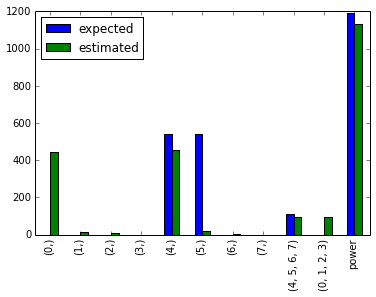

In [17]:
def df_for_graph(power):
    # Convert a dict to a DataFrame that can be used to display a bar graph
    # Order the bars by key length - so CPU-level numbers are first, then cluster numbers, then the total ("power")
    items = sorted(power.items(), key=lambda (k, v): len(k))
    [keys, vals] = zip(*items)
    return pd.DataFrame(list(vals), index=list(keys))

assert estimated.keys() == expected.keys()

df_exp = df_for_graph(expected)
df_est = df_for_graph(estimated)

df = pd.concat([df_exp, df_est], axis=1, join_axes=[df_exp.index])
df.columns = ["expected", "estimated"]
df.plot(kind="bar")

05:15:15  INFO    : LITTLE cluster average frequency: 1.153 GHz
05:15:15  INFO    : big    cluster average frequency: 1.153 GHz


(1.152689518530889, 1.1527271242751949)

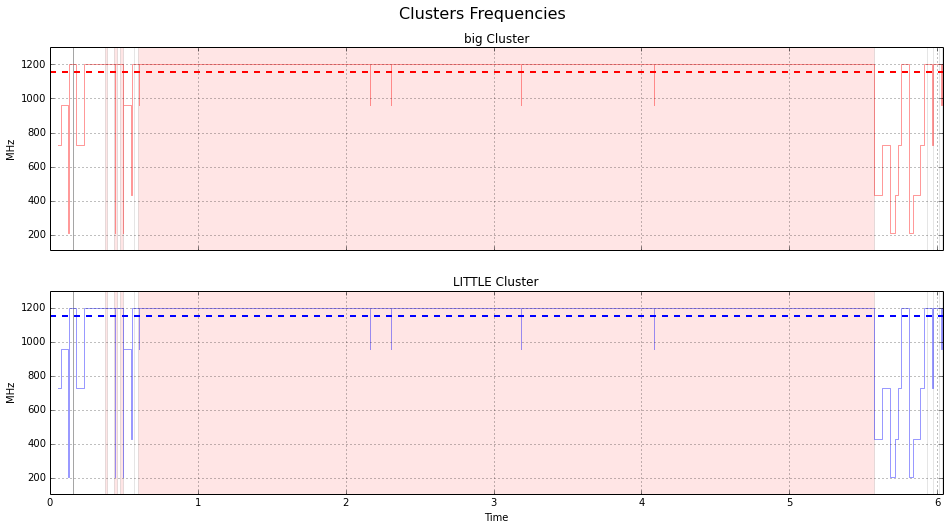

In [18]:
trace.analysis.frequency.plotClusterFrequencies()

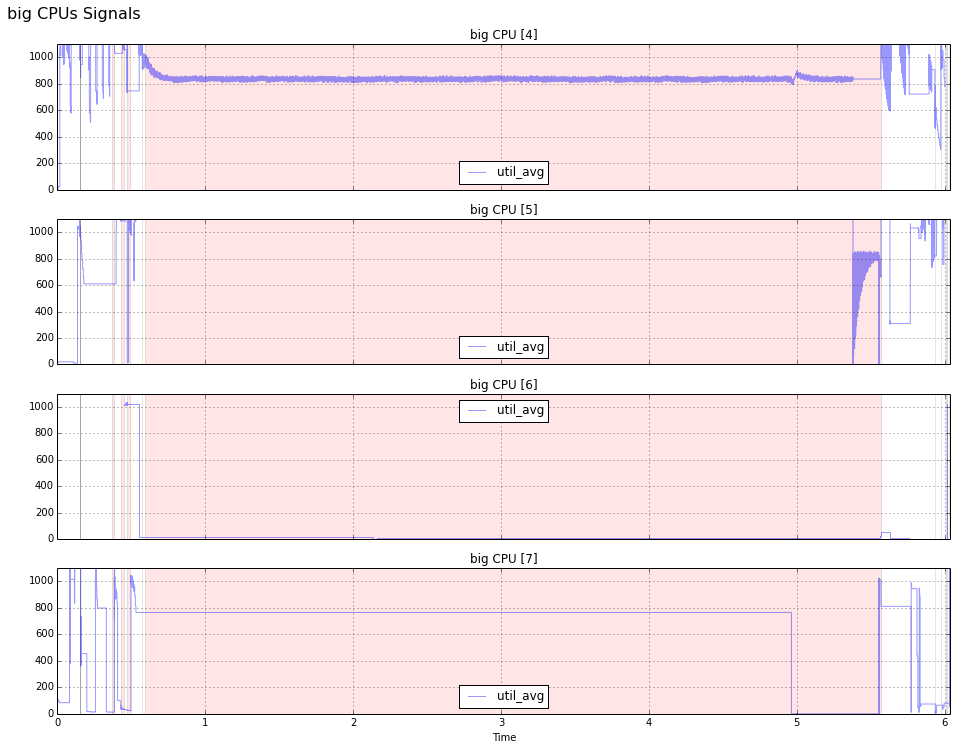

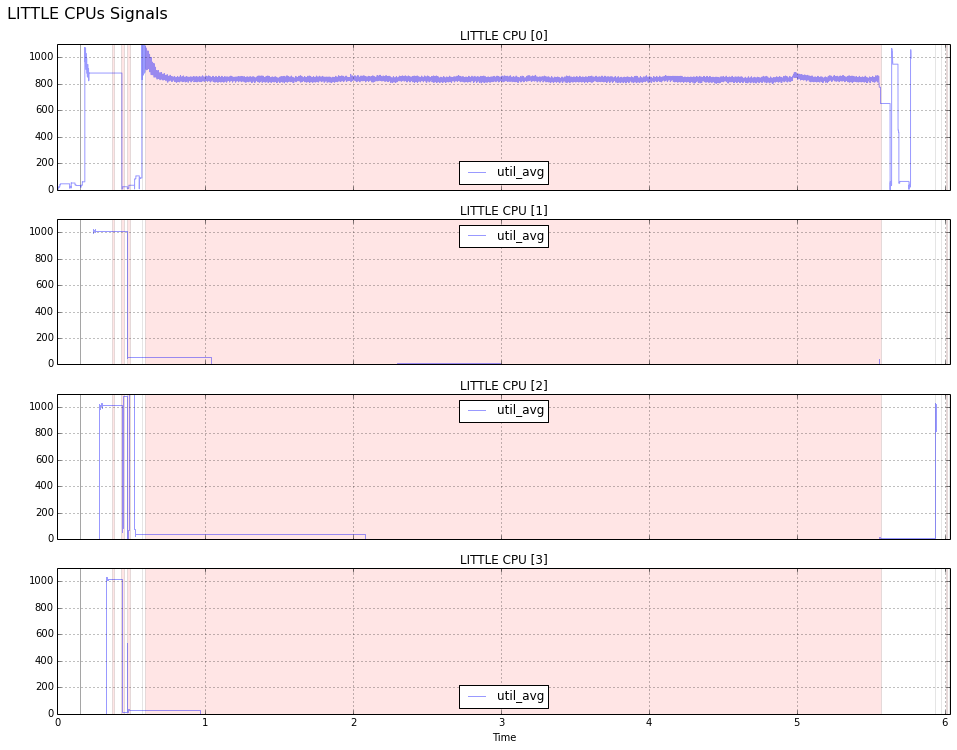

In [19]:
trace.analysis.cpus.plotCPU()

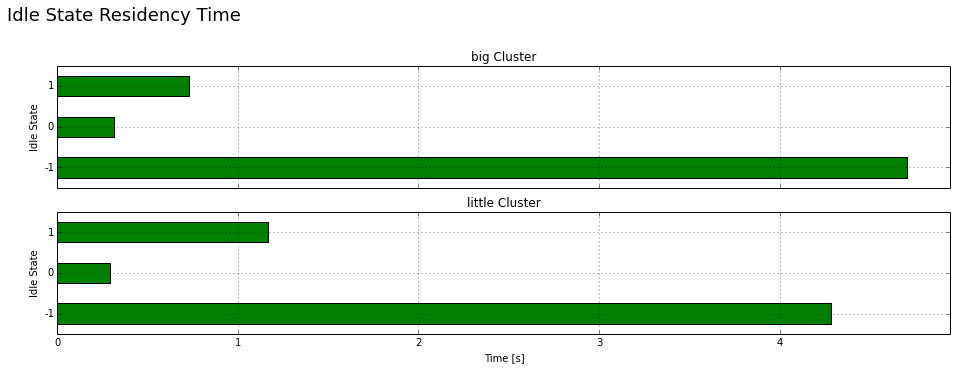

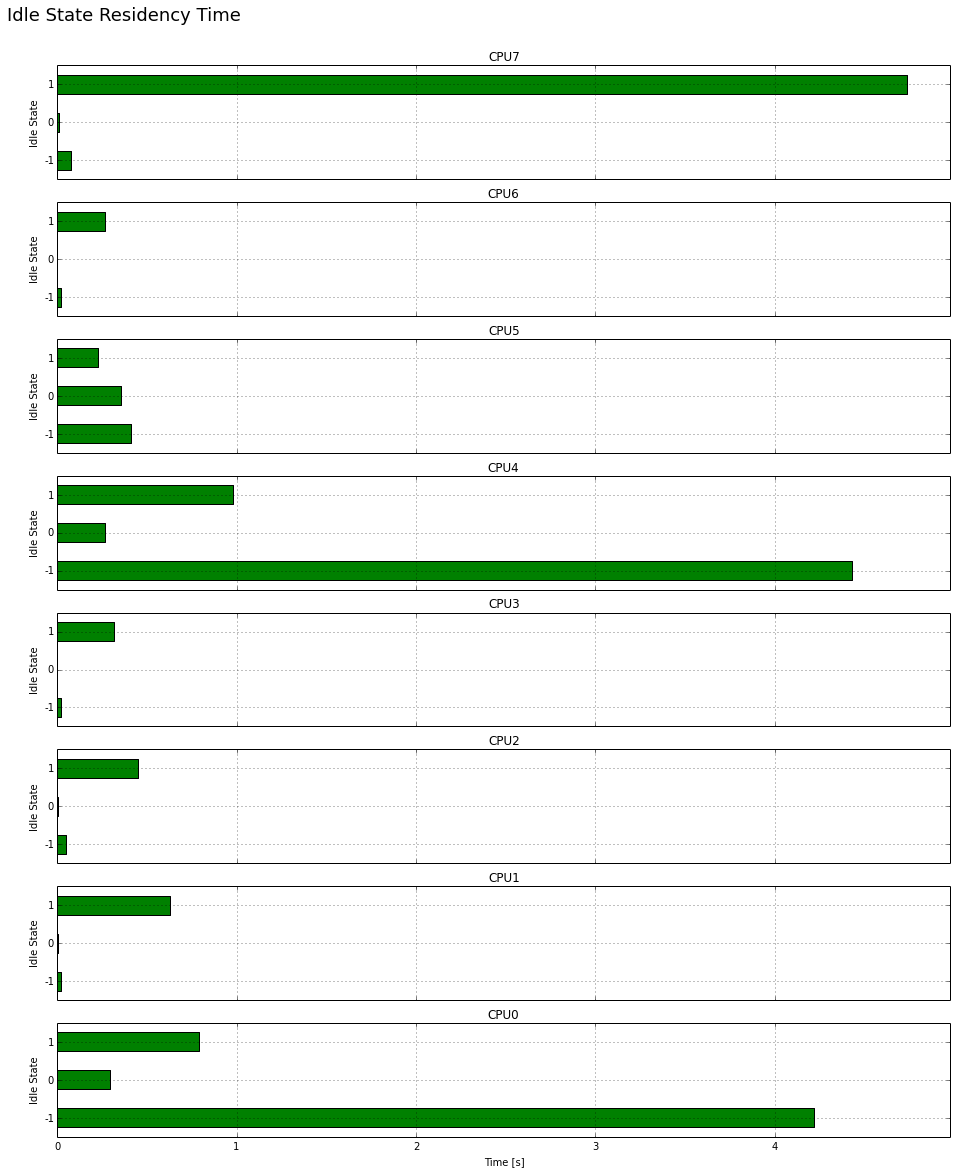

In [20]:
trace.analysis.idle.plotClusterIdleStateResidency()
trace.analysis.idle.plotCPUIdleStateResidency()